In [1]:
import math
import numpy as np
import pandas as pd
import numpy.linalg as la
import matplotlib.pyplot as plt

import scipy.stats as ss

In [2]:
file = r'donnee.xlsx'
df = pd.read_excel(file)
del df['Unnamed: 0']

In [3]:
temps = df['Temps'].values
s_true = df['signalReel'].values
s_noise = df['signalBruite'].values

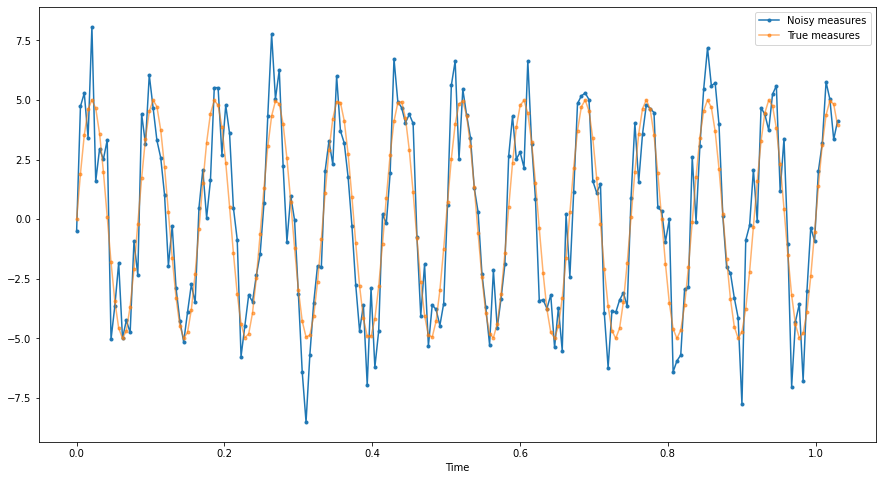

In [4]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.plot(temps[:200], s_noise[:200], '.-', label='Noisy measures')
ax.plot(temps[:200], s_true[:200], '.-', alpha=0.6, label='True measures')
ax.set_xlabel('Time')
ax.legend()
plt.show()

In [5]:
A = np.identity(2)
Q = np.array([[2e-5, 0], [0, 2e-1]])
R = 3
nu0, nu_ech = 12, 193.28
Te = 1/nu_ech

In [6]:
def f(x) :
    return A@x

def F(x) :
    return np.eye(2)

def h(x, y, k) :
    return x*np.sin(2*np.pi*nu0*k*Te + y)

def H(x, y, k) :
    return np.array([np.sin(2*np.pi*nu0*k*Te + y), 
                    x*np.cos(2*np.pi*nu0*k*Te + y)]).reshape((2, 1))

def Kalmann_filter(Q, R, f, F, h, H, z) :
    """
    Apply the Extended Kalman filter to the measures z to estimate the state variables
    
    Args:
        Q (int): the variance of the state noise
        
        R (int): the variance of the measure noise
        
        z (array): array of measures
        
    Returns:
        array: estimated and predicted state variables
    """
    
    n = len(z)
    P = np.eye(2)
    x = np.random.normal(size=2).reshape((2, 1))
    xh_l, P_l = [], []
    for k in range(n) :
        # estimation at time k
        xh_t = x.copy().reshape((2, 1))
        # std at time k
        P_t = P + Q
        
        H_t = H(xh_t[0, 0], xh_t[1, 0], k+1) #2x1
        S = np.array(H_t.T@P_t@H_t + R) #1x1
        K = (P_t@H_t/S).reshape((2, 1)) #2x1
        err = z[k] - h(xh_t[0, 0], xh_t[1, 0], k+1) #1x1
        #prediction au temps k + 1
        x = xh_t + K*err
        P = P_t - K@H_t.T@P_t
        
        xh_l.append(x) #2x1
        P_l.append(P) #2x2

    xh = np.array(xh_l).reshape((len(xh_l), 2))
    return xh

In [7]:
xh_l = Kalmann_filter(Q, R, f, F, h, H, s_noise)

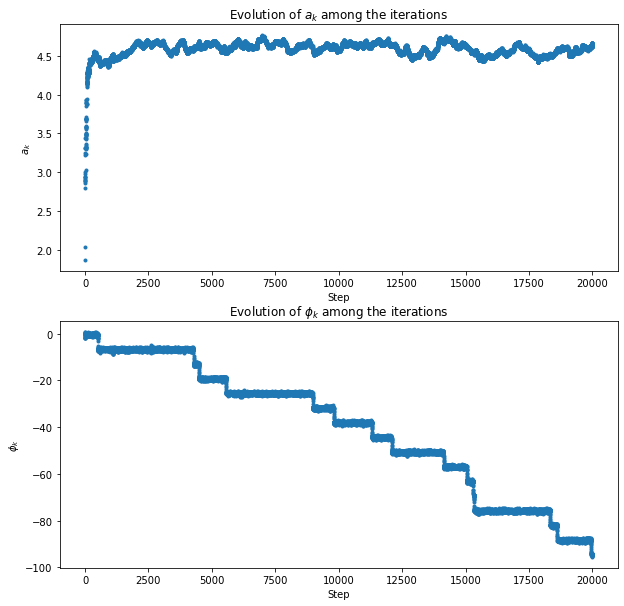

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
ax1.plot(xh_l[:, 0], '.')
ax1.set_xlabel('Step')
ax1.set_ylabel(r'$a_k$')
ax1.set_title(r'Evolution of $a_k$ among the iterations')

ax2.plot(xh_l[:, 1], '.')
ax2.set_xlabel('Step')
ax2.set_ylabel(r'$\phi_k$')
ax2.set_title(r'Evolution of $\phi_k$ among the iterations')
plt.show()

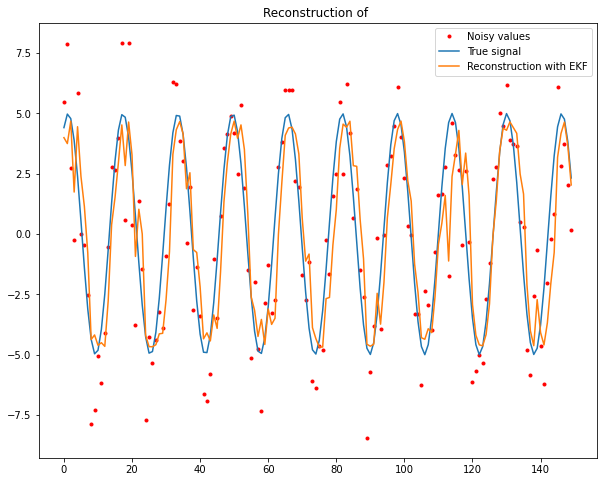

In [9]:
idx = np.arange(20000)
s_ekf = xh_l[:, 0]*np.sin(2*np.pi*nu0*Te*idx + xh_l[:, 1])

nmin = 2000
nmax = nmin + 150

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.plot(s_noise[nmin:nmax], 'r.', label='Noisy values')
ax.plot(s_true[nmin:nmax], label='True signal')
ax.plot(s_ekf[nmin:nmax], label='Reconstruction with EKF')
ax.set_title('Reconstruction of ')
ax.legend()
plt.show()

By applying the Extended Kalmann Filter to the noisy signal, we can reconstruct quite well the true signal (compared to the noisy one).